In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random

# =============================
# 1. 数据生成与处理
# =============================

# 设置随机种子，保证可重复
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# 定义图像尺寸和序列长度
IMG_H, IMG_W = 100, 100
SEQ_LEN = 50

# 生成一张固定的高程图（灰度值归一化到 [0,1]）
# 这里使用高斯滤波的随机噪声模拟地形
base_map = np.random.rand(IMG_H, IMG_W)
from scipy.ndimage import gaussian_filter
elevation_map = gaussian_filter(base_map, sigma=10)  # 平滑处理
elevation_map = elevation_map.astype(np.float32)
# 将图像归一化（可选步骤，这里数值本身已在 [0,1] 范围内）
elevation_map = (elevation_map - elevation_map.min()) / (elevation_map.max() - elevation_map.min())

# 辅助函数：给定角度，计算通过图像中心的直线与边界的交点
def get_line_endpoints(center, angle):
    cx, cy = center
    # 计算参数 t，使得 (x=0 or x=IMG_W or y=0 or y=IMG_H)
    dx = np.cos(angle)
    dy = np.sin(angle)
    ts = []
    # 左边界 x=0
    if dx != 0:
        t = (0 - cx) / dx
        y = cy + t * dy
        if 0 <= y <= IMG_H:
            ts.append(t)
    # 右边界 x=IMG_W
    if dx != 0:
        t = (IMG_W - cx) / dx
        y = cy + t * dy
        if 0 <= y <= IMG_H:
            ts.append(t)
    # 底边界 y=0
    if dy != 0:
        t = (0 - cy) / dy
        x = cx + t * dx
        if 0 <= x <= IMG_W:
            ts.append(t)
    # 顶边界 y=IMG_H
    if dy != 0:
        t = (IMG_H - cy) / dy
        x = cx + t * dx
        if 0 <= x <= IMG_W:
            ts.append(t)
    if not ts:
        return None
    t_min = min(ts)
    t_max = max(ts)
    # 两个端点坐标
    p1 = (cx + t_min * dx, cy + t_min * dy)
    p2 = (cx + t_max * dx, cy + t_max * dy)
    return p1, p2

# 辅助函数：沿直线均匀采样 N 个点，获取高度值（双线性插值）并加噪声
def sample_line(elevation_map, N):
    """返回采样序列的坐标和带噪声的高程值。"""
    H, W = elevation_map.shape
    center = (W/2, H/2)
    # 随机选角度
    angle = random.uniform(0, 2*np.pi)
    endpoints = get_line_endpoints(center, angle)
    if endpoints is None:
        return None  # 若意外未交到边界（理论上不会发生）
    (x1, y1), (x2, y2) = endpoints
    # 均匀采样 N 个点
    xs = np.linspace(x1, x2, N)
    ys = np.linspace(y1, y2, N)
    # 双线性插值获取高度值
    # 限制采样点在图像范围内
    xs_clip = np.clip(xs, 0, W-1)
    ys_clip = np.clip(ys, 0, H-1)
    # 整数和小数部分
    x0 = np.floor(xs_clip).astype(int)
    y0 = np.floor(ys_clip).astype(int)
    x1i = np.ceil(xs_clip).astype(int)
    y1i = np.ceil(ys_clip).astype(int)
    # 插值权重
    dx = xs_clip - x0
    dy = ys_clip - y0
    heights = ( (1-dx)*(1-dy)*elevation_map[y0, x0] +
                dx*(1-dy)*elevation_map[y0, x1i] +
                (1-dx)*dy*elevation_map[y1i, x0] +
                dx*dy*elevation_map[y1i, x1i] )
    # 加入高斯噪声
    noise = np.random.normal(scale=0.01, size=heights.shape)
    heights_noisy = heights + noise
    return (xs, ys), heights_noisy

# 测试采样函数，获取一个序列示例
(coord_seq, height_seq) = sample_line(elevation_map, SEQ_LEN)
# coord_seq 是两个数组 (xs, ys)，height_seq 是对应的高度值序列

# 构建训练集和测试集
NUM_TRAIN = 1000
NUM_TEST = 200

train_seqs = []
train_coords = []
for _ in range(NUM_TRAIN):
    sample = sample_line(elevation_map, SEQ_LEN)
    if sample is None:
        continue
    (xs, ys), heights = sample
    train_seqs.append(heights.astype(np.float32))
    # 保存真实坐标并归一化到 [0,1]
    xs_norm = xs / IMG_W
    ys_norm = ys / IMG_H
    coords_norm = np.stack([xs_norm, ys_norm], axis=1)  # shape (N,2)
    train_coords.append(coords_norm.astype(np.float32))

test_seqs = []
test_coords = []
for _ in range(NUM_TEST):
    sample = sample_line(elevation_map, SEQ_LEN)
    if sample is None:
        continue
    (xs, ys), heights = sample
    test_seqs.append(heights.astype(np.float32))
    xs_norm = xs / IMG_W
    ys_norm = ys / IMG_H
    coords_norm = np.stack([xs_norm, ys_norm], axis=1)
    test_coords.append(coords_norm.astype(np.float32))

train_seqs = np.array(train_seqs)   # shape (NUM_TRAIN, N)
train_coords = np.array(train_coords)  # shape (NUM_TRAIN, N, 2)
test_seqs = np.array(test_seqs)
test_coords = np.array(test_coords)

# 转换为 PyTorch 的 TensorDataset
# 图像输入在每次训练中相同，可直接在训练循环中使用同一个 elevation_map_tensor
elevation_map_tensor = torch.tensor(elevation_map).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

train_seq_tensor = torch.tensor(train_seqs)        # (NUM_TRAIN, N)
train_coords_tensor = torch.tensor(train_coords)   # (NUM_TRAIN, N, 2)
test_seq_tensor = torch.tensor(test_seqs)
test_coords_tensor = torch.tensor(test_coords)

# 为便于 DataLoader 处理，将序列与坐标展平
train_seq_tensor = train_seq_tensor.unsqueeze(1)  # (NUM_TRAIN, 1, N)
test_seq_tensor = test_seq_tensor.unsqueeze(1)

# 建立 Dataset（图像用全局固定图像）
train_dataset = TensorDataset(train_seq_tensor, train_coords_tensor)
test_dataset = TensorDataset(test_seq_tensor, test_coords_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# =============================
# 2. 模型定义：融合CNN和序列输入
# =============================

class FusionNet(nn.Module):
    def __init__(self, img_h, img_w, seq_len):
        super(FusionNet, self).__init__()
        self.img_h, self.img_w = img_h, img_w
        self.seq_len = seq_len
        # 图像卷积分支：输入 (B,1,H,W) -> 特征向量
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 输出 (B,16,H,W)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,16,H/2,W/2)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (B,32,H/2,W/2)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,32,H/4,W/4)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B,64,H/4,W/4)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # (B,64,1,1)
        )
        # 将 CNN 输出展平
        self.cnn_fc = nn.Linear(64, 128)  # (B,128)
        
        # 序列分支：输入 (B,1,N) -> 特征向量
        self.seq_net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),  # (B,16,N)
            nn.ReLU(),
            nn.MaxPool1d(2),  # (B,16,N/2)
            nn.Conv1d(16, 32, kernel_size=3, padding=1),  # (B,32,N/2)
            nn.ReLU(),
            nn.MaxPool1d(2),  # (B,32,N/4)
            nn.Flatten(),     # (B, 32*(N/4))
        )
        # 计算序列分支输出维度
        dummy_input = torch.zeros(1, 1, seq_len)
        seq_feat_dim = self.seq_net(dummy_input).shape[1]
        self.seq_fc = nn.Linear(seq_feat_dim, 128)  # (B,128)
        
        # 最终融合：将两个特征拼接后预测 2*N 个坐标值
        self.final_fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 2*seq_len)  # 输出长度为 2*N
        )

    def forward(self, img, seq):
        # 图像分支
        x = self.cnn(img)           # (B,64,1,1)
        x = x.view(x.size(0), -1)   # (B,64)
        x = self.cnn_fc(x)          # (B,128)
        # 序列分支
        s = self.seq_net(seq)       # (B, 32*(N/4))
        s = self.seq_fc(s)          # (B,128)
        # 特征融合
        feat = torch.cat([x, s], dim=1)  # (B,256)
        out = self.final_fc(feat)        # (B, 2*N)
        # reshape 输出为 (B,N,2) 方便理解
        out = out.view(-1, self.seq_len, 2)
        return out

# 实例化模型、定义损失与优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionNet(IMG_H, IMG_W, SEQ_LEN).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# =============================
# 3. 模型训练
# =============================

num_epochs = 200
print("开始训练...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_seq, batch_coords in train_loader:
        # batch_seq: (B,1,N)， batch_coords: (B,N,2)
        batch_size = batch_seq.size(0)
        # 准备图像输入（固定图像重复 B 次）
        imgs = elevation_map_tensor.expand(batch_size, -1, -1, -1).to(device)  # (B,1,H,W)
        seqs = batch_seq.to(device)
        targets = batch_coords.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs, seqs)  # (B,N,2)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] 平均损失: {avg_loss:.6f}")

print("训练完成。")


# =============================
# 4. 模型测试与结果展示
# =============================

model.eval()
with torch.no_grad():
    total_mse = 0.0
    for batch_seq, batch_coords in test_loader:
        batch_size = batch_seq.size(0)
        imgs = elevation_map_tensor.expand(batch_size, -1, -1, -1).to(device)
        seqs = batch_seq.to(device)
        targets = batch_coords.to(device)
        outputs = model(imgs, seqs)
        total_mse += criterion(outputs, targets).item()
    avg_mse = total_mse / len(test_loader)
    print(f"测试集上的平均 MSE: {avg_mse:.6f}")

# 显示部分预测结果示例
print("\n示例预测:")
# 从测试集随机选择一个样本查看坐标预测
idx = random.randint(0, len(test_seqs)-1)
sample_seq = torch.tensor(test_seqs[idx]).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,N)
with torch.no_grad():
    pred = model(elevation_map_tensor.to(device), sample_seq)  # (1,N,2)
pred = pred.squeeze(0).cpu().numpy()  # (N,2)
truth = test_coords[idx]  # (N,2)

# 打印前10个点的真实 vs 预测坐标（已归一化到 [0,1]）
for i in range(10):
    tx, ty = truth[i]
    px, py = pred[i]
    print(f"点 {i}: 真实 ({tx:.3f}, {ty:.3f}) -> 预测 ({px:.3f}, {py:.3f})")


开始训练...
Epoch [1/200] 平均损失: 0.099244
Epoch [5/200] 平均损失: 0.025921
Epoch [10/200] 平均损失: 0.001358
Epoch [15/200] 平均损失: 0.000407
Epoch [20/200] 平均损失: 0.000386
Epoch [25/200] 平均损失: 0.000319
Epoch [30/200] 平均损失: 0.000282
Epoch [35/200] 平均损失: 0.000185
Epoch [40/200] 平均损失: 0.000162
Epoch [45/200] 平均损失: 0.000168
Epoch [50/200] 平均损失: 0.000148
Epoch [55/200] 平均损失: 0.000155
Epoch [60/200] 平均损失: 0.000145
Epoch [65/200] 平均损失: 0.000090
Epoch [70/200] 平均损失: 0.000086
Epoch [75/200] 平均损失: 0.000103
Epoch [80/200] 平均损失: 0.000095
Epoch [85/200] 平均损失: 0.000080
Epoch [90/200] 平均损失: 0.000053
Epoch [95/200] 平均损失: 0.000057
Epoch [100/200] 平均损失: 0.000064
Epoch [105/200] 平均损失: 0.000049
Epoch [110/200] 平均损失: 0.000063
Epoch [115/200] 平均损失: 0.000053
Epoch [120/200] 平均损失: 0.000049
Epoch [125/200] 平均损失: 0.000059
Epoch [130/200] 平均损失: 0.000050
Epoch [135/200] 平均损失: 0.000047
Epoch [140/200] 平均损失: 0.000066
Epoch [145/200] 平均损失: 0.000040
Epoch [150/200] 平均损失: 0.000050
Epoch [155/200] 平均损失: 0.000041
Epoch [160/200] 平均损失: 

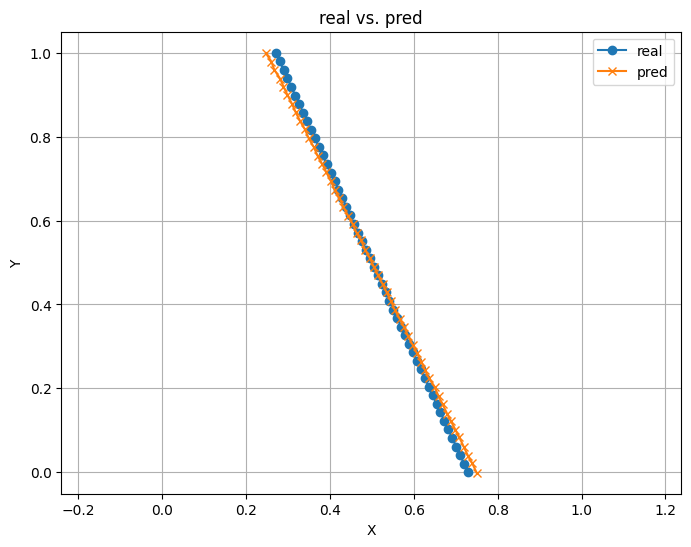

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 设：model 是训练好的模型，test_loader 是测试集数据加载器

# 1. 随机获取一条测试样本
sample_input, sample_target = next(iter(test_loader))  # 获取一个 batch
sample_input = sample_input[0].unsqueeze(0)  # [1, seq_len, feature_dim]
sample_target = sample_target[0]  # [seq_len, output_dim]

# 2. 预测
model.eval()
with torch.no_grad():
    prediction = model(elevation_map_tensor.to(device), sample_input)  # [1, seq_len, output_dim]
    prediction = prediction.squeeze(0).cpu().numpy()

# 3. 提取真实轨迹
true_trajectory = sample_target.cpu().numpy()

# 4. 可视化
plt.figure(figsize=(8, 6))
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], label='real', marker='o')
plt.plot(prediction[:, 0], prediction[:, 1], label='pred', marker='x')
plt.title('real vs. pred')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()
